# Example

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
from numpy import pi
import matplotlib
import matplotlib.pylab as plt
import newtonprop
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
matplotlib  3.0.2
matplotlib.pylab  1.15.4
newtonprop  0.1.0
CPython 3.6.7
IPython 7.2.0


## QuTiP Model

We consider the example of a driven harmonic oscillator with spontaneous decay, truncated to 10-levels. The dynamics start from the totally mixed state.

In [2]:
def liouvillian(N=10):

    two_pi = 2.0 * pi
    w_c = two_pi * 0.01
    gamma = two_pi * 0.1
    E0 = 0.5

    # Drift Hamiltonian
    H0 = np.array(np.zeros(shape=(N, N), dtype=np.complex128))
    for i in range(N):
        H0[i, i] = i * w_c

    # Control Hamiltonian
    H1 = np.array(np.zeros(shape=(N, N), dtype=np.complex128))
    for i in range(1, N):
        H1[i-1, i] = np.sqrt(float(i))
        H1[i, i-1] = H1[i-1, i]

    # Total Hamiltonian
    H = H0 + E0 * H1

    # Dissipator
    a = np.array(np.zeros(shape=(N, N), dtype=np.complex128))
    for i in range(1, N):
        a[i-1, i] = np.sqrt(i)

    a_dag = a.conj().T

    return qutip.Qobj(H), [qutip.Qobj(a), ]

In [3]:
def rho_mixed(N=10):
    rho = np.matrix(np.zeros(shape=(N, N), dtype=np.complex128))
    rho[:, :] = 1.0 / float(N)
    return qutip.Qobj(rho)

In [4]:
H, c_ops = liouvillian()

In [5]:
rho0 = rho_mixed()

In [6]:
L = qutip.liouvillian(H, c_ops)

In [7]:
tlist = np.linspace(0, 10, 100)

## Reference Dynamics

We can use QuTiP's `mesolve` routine to analyze the system dynamics:

In [8]:
result_mesolve = qutip.mesolve(L, rho0, tlist)

In [9]:
def plot_pop_dynamcis(result):
    data = np.array([state.diag() for state in result.states])
    fig, ax = plt.subplots()
    n = data.shape[1]
    for level in range(n):
        ax.plot(result.times, np.real(data[:, level]), label="%d" % (level+1))
    ax.legend()
    plt.show(fig)

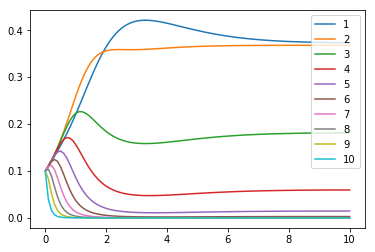

In [10]:
plot_pop_dynamcis(result_mesolve)

For comparison with the Newton propagator which is supposed to be exect to a pre-specified limit ($10^{-12}$, by default), it is better if we can compare to the propagation that results from exactly exponentiating the Liouvillian.

In [11]:
class Result():
    """Dummy class for propagation result"""
    pass

In [12]:
def propagate_expm(L, rho0, tlist):
    result = Result()
    result.times = tlist
    dt = tlist[1] - tlist[0]
    states = [rho0, ]
    rho = rho0
    E = (L * dt).expm()
    for _ in range(len(tlist)-1):
        rho = E(rho)
        states.append(rho)
    result.states = states
    return result

In [13]:
result_expm = propagate_expm(L, rho0, tlist)

In [14]:
def error(result1, result2):
    err = np.linalg.norm(
          result1.states[-1].full()
        - result2.states[-1].full())
    print("%.1e" % err)

This is our "exact baseline". The `mesolve` routine is only exact to about $10^{-7}$.

In [15]:
error(result_mesolve, result_expm)

1.2e-07


## Newton propagation of QuTiP objects

First, we use the Newton propagator to simulate the dynamics using QuTiP objects.

In [16]:
def zero_qutip(v):
    return qutip.Qobj(np.zeros(shape=v.shape))

def norm_qutip(v):
    return v.norm("fro")

def inner_qutip(a, b):
    return complex((a.dag() * b).tr())

def propagate(L, rho0, tlist, zero, norm, inner, tol=1e-12):
    result = Result()
    result.times = tlist
    dt = tlist[1] - tlist[0]
    states = [rho0]
    rho = rho0
    for _ in range(len(tlist) - 1):
        rho = newtonprop.newton(
            L, rho, dt, func='exp', zero=zero, norm=norm, inner=inner, tol=tol
        )
        states.append(rho)
    result.states = states
    return result

Using the Frobenious norm here is absolutely critical: QuTiP's default norm is not compatible with the inner product, and will lead to a subtle error.

In [17]:
result_qutip = propagate(L, rho0, tlist, zero_qutip, norm_qutip, inner_qutip, tol=1e-12)

In [18]:
error(result_qutip, result_expm)

8.7e-11


In [19]:
result_qutip = propagate(L, rho0, tlist, zero_qutip, norm_qutip, inner_qutip, tol=1e-8)

In [20]:
error(result_qutip, result_expm)

1.3e-09


## Newton propagation of QuTiP objects with Cython

In [21]:
from qutip.cy.spmatfuncs import cy_ode_rhs
from qutip.superoperator import mat2vec

In [22]:
L_data = L.data.data
L_indices = L.data.indices
L_indptr = L.data.indptr
rho0_data = mat2vec(rho0.full()).ravel('F')

def zero_vectorized(v):
    return np.zeros(shape=v.shape, dtype=v.dtype)

def norm_vectorized(v):
    return np.linalg.norm(v)

def inner_vectorized(a, b):
    return np.vdot(a, b)

def apply_cythonized_L(rho_data):
    return cy_ode_rhs(0, rho_data, L_data, L_indices, L_indptr)

In [23]:
result_qutip_cython = propagate(apply_cythonized_L, rho0_data, tlist, zero_vectorized, norm_vectorized, inner_vectorized)

In [24]:
N = rho0.shape[0]
result_qutip_cython.states = [
    qutip.Qobj(rho.reshape((N,N), order='F'))
    for rho in result_qutip_cython.states]

In [25]:
error(result_qutip_cython, result_expm)

3.5e-11


## Newton propagation of vectorized state

Second, we do the same dynamics, but using equivalent numpy arrays and matrices

In [26]:
def zero_vectorized(v):
    return np.zeros(shape=v.shape, dtype=v.dtype)

def norm_vectorized(v):
    return np.linalg.norm(v)

def inner_vectorized(a, b):
    return np.vdot(a, b)

rho0_vectorized = qutip.operator_to_vector(rho0).full().flatten()
Lmatrix = L.full()

def L_vectorized(v):
    return Lmatrix @ v

In [27]:
result_vectorized = propagate(L_vectorized, rho0_vectorized, tlist, zero_vectorized, norm_vectorized, inner_vectorized)

In [28]:
N = rho0.shape[0]
result_vectorized.states = [
    qutip.Qobj(rho.reshape((N,N), order='F'))
    for rho in result_vectorized.states]

In [29]:
error(result_vectorized, result_expm)

3.5e-11
